# Predictive Maintenance Classification with Imbalance Handling & GPU Acceleration

## Thesis Objective
This notebook forms part of a thesis investigating effective methods for handling class imbalance in predictive maintenance classification tasks. We aim to compare standard classifiers (Random Forest, SVM) under various data sampling strategies to determine which approaches yield the best predictive performance for identifying machine failures from sensor data. This version incorporates **optional GPU acceleration** for the computationally intensive GAN training step using the **TabGAN** library.

## Notebook Structure
1.  **Setup:** Import libraries and provide environment setup guidance (including GPU support for TabGAN).
2.  **GPU Check:** Verify if a compatible GPU is detected (useful for general awareness, TabGAN uses PyTorch/CUDA).
3.  **Load Data:** Load the `predictive_maintenance.csv` dataset.
4.  **Exploratory Data Analysis (EDA):** Analyze the data's characteristics, distributions, correlations, and visualize the extent of class imbalance.
5.  **Data Preprocessing:** Prepare the data for modeling using techniques like one-hot encoding and feature scaling, encapsulated within a `ColumnTransformer`.
6.  **Modeling Scenarios:**
    *   Scenario 1: Baseline (No Resampling)
    *   Scenario 2: Random Undersampling
    *   Scenario 3: SMOTE Oversampling
    *   Scenario 4: GAN Oversampling (**TabGAN**) - *GPU Accelerated if available*
7.  **Model Training & Hyperparameter Tuning:** Train Random Forest and SVM models using `GridSearchCV` within each scenario.
8.  **Evaluation:** Assess model performance using standard classification metrics (Accuracy, Precision, Recall, F1, ROC-AUC).
9.  **Results Comparison:** Compile and visualize the results across all scenarios and models.
10. **Conclusion:** Discuss the findings regarding the effectiveness of different sampling techniques.
11. **Troubleshooting:** Offer guidance on potential library issues (including GPU setup for TabGAN).

## 1. Setup

This section imports necessary libraries and provides instructions for setting up the Python environment, including **optional GPU acceleration via CUDA** for TabGAN.

**Environment Notes:**
*   This notebook is designed to run in a Python 3.9 or 3.10 environment (e.g., an Anaconda environment named `thesis_env`).
*   Ensure the required libraries are installed using the versions specified below for better compatibility.

**Installation Instructions:**
```bash
# Install core ML libraries, visualization tools, and TabGAN
# Use pip within your activated conda environment
pip install pandas numpy scikit-learn==1.2.2 imbalanced-learn==0.10.1 matplotlib==3.7.1 seaborn==0.12.2 tabgan ipywidgets notebook

# Optional: Install PyTorch with CUDA support IF you want TabGAN GPU acceleration
# Visit https://pytorch.org/get-started/locally/ to get the correct command for your CUDA version.
# Example (check PyTorch website for current commands for your CUDA version, e.g., cu118, cu121):
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 
```

*Note on TabGAN & Dependencies:* `tabgan` uses PyTorch for its GAN implementation. Ensure you have a compatible PyTorch version installed, especially if using GPU acceleration.

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
import time # To measure execution time

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# Imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# Pipeline compatible with imblearn transformers
from imblearn.pipeline import Pipeline as ImbPipeline

# TabGAN (for GAN Oversampling)
try:
    from tabgan.sampler import GANGenerator
    import torch # TabGAN uses PyTorch
    GAN_AVAILABLE = True
    PYTORCH_AVAILABLE = True
except ImportError as e:
    print(f"Warning: TabGAN or PyTorch could not be imported. GAN scenario will be skipped. Error: {e}")
    print("Try installing with: pip install tabgan torch torchvision torchaudio")
    GANGenerator = None # Define as None if import fails
    GAN_AVAILABLE = False
    PYTORCH_AVAILABLE = False


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
# %matplotlib inline # Magic command for Jupyter frontends

print("Libraries imported.")
if PYTORCH_AVAILABLE:
    print(f"PyTorch Version: {torch.__version__}")
if GAN_AVAILABLE:
    print("TabGAN (for GAN Oversampling) is available.")
else:
    print("TabGAN could not be loaded. GAN scenario will be skipped.")

Libraries imported.
PyTorch Version: 2.5.1
TabGAN (for GAN Oversampling) is available.


## 2. GPU Check

This cell checks if a CUDA-enabled GPU is available for PyTorch (used by TabGAN) and optionally provides TensorFlow GPU info if installed.

In [2]:
gpu_available_for_tabgan = False
if PYTORCH_AVAILABLE:
    if torch.cuda.is_available():
        print(f"SUCCESS: PyTorch detected CUDA-enabled GPU: {torch.cuda.get_device_name(0)}")
        print("TabGAN will attempt to use the GPU if available.")
        gpu_available_for_tabgan = True
    else:
        print("INFO: PyTorch did not detect a CUDA-enabled GPU. TabGAN will run on CPU.")
else:
    print("INFO: PyTorch not available, cannot check for GPU for TabGAN.")


SUCCESS: PyTorch detected CUDA-enabled GPU: NVIDIA GeForce GTX 1060 with Max-Q Design
TabGAN will attempt to use the GPU if available.


## 3. Load Data

Load the dataset from the provided `predictive_maintenance.csv` file into a pandas DataFrame.

In [3]:
# Load the dataset
try:
    df = pd.read_csv('predictive_maintenance.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: predictive_maintenance.csv not found. Please ensure the file is in the same directory as the notebook.")
    exit() # Exit if data is essential

# Display basic information
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nDataset Information:")
df.info()

print("\nDescriptive Statistics:")
display(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

Dataset loaded successfully.
Dataset shape: (10000, 10)

First 5 rows of the dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB

Descriptive Statistics:


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000



Missing Values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


**Initial Observations:**
*   Dataset has 10,000 rows, 10 columns. No missing values.
*   Includes identifiers, machine type (categorical), sensor readings (numerical), target (binary failure), and failure type details.

## 4. Exploratory Data Analysis (EDA)

Analyze data characteristics, distributions, correlations, and class imbalance.

### 4.1 Target Variable Analysis

Target Variable Distribution:
Target
0    9661
1     339
Name: count, dtype: int64

Percentage Distribution:
Target
0    96.61
1     3.39
Name: proportion, dtype: float64


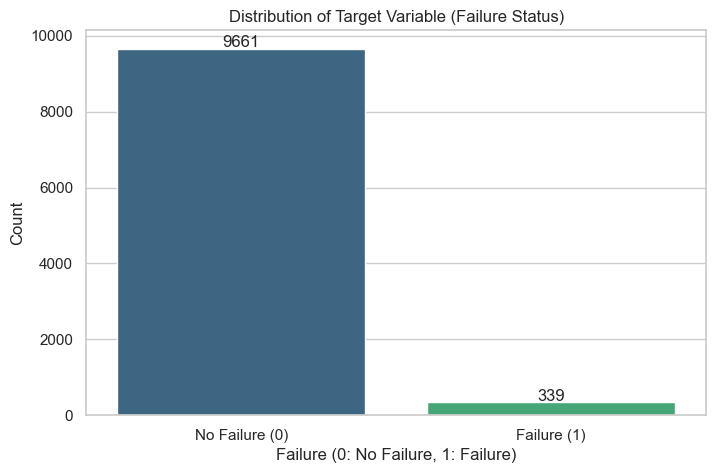

In [4]:
print("Target Variable Distribution:")
target_counts = df['Target'].value_counts()
target_perc = df['Target'].value_counts(normalize=True) * 100
print(target_counts)
print(f"\nPercentage Distribution:\n{target_perc}")

# Visualize the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Distribution of Target Variable (Failure Status)')
plt.xlabel('Failure (0: No Failure, 1: Failure)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Failure (0)', 'Failure (1)'])
for index, value in enumerate(target_counts):
    plt.text(index, value + 50, str(value), ha='center') # Add count labels
plt.show()

**Target Variable Insights:** Highly imbalanced (3.39% failures). Requires special handling.

### 4.2 Failure Type Analysis

Failure Type Distribution (where Target = 1):
Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Name: count, dtype: int64


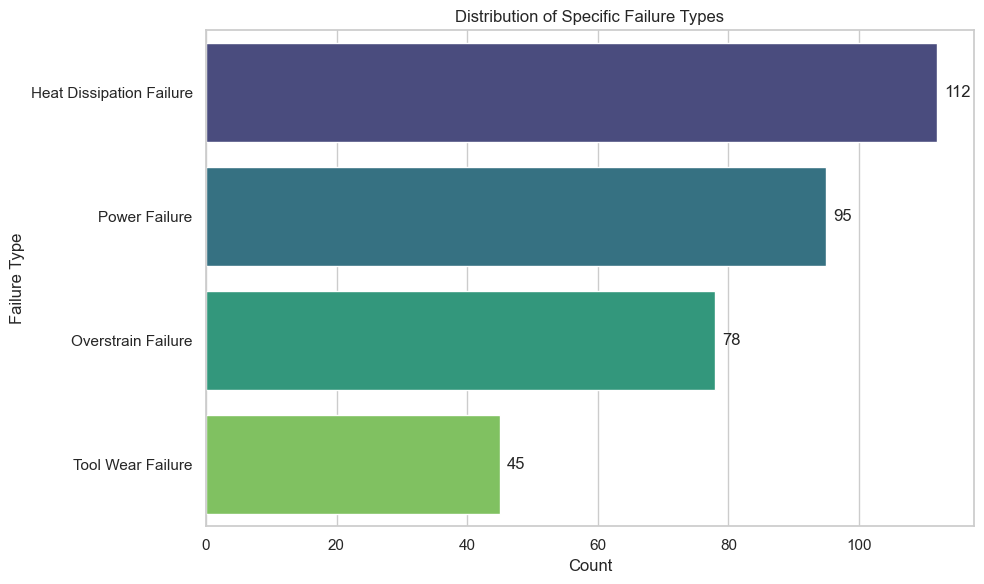

In [5]:
print("Failure Type Distribution (where Target = 1):")
failure_df = df[df['Target'] == 1]
failure_type_counts = failure_df['Failure Type'].value_counts()
# Filter out 'No Failure' entries that might be mislabeled within Target=1 subset if any
failure_type_counts = failure_type_counts[failure_type_counts.index != 'No Failure']
print(failure_type_counts)

# Visualize failure types
plt.figure(figsize=(10, 6))
sns.countplot(y='Failure Type', data=failure_df[failure_df['Failure Type'] != 'No Failure'], order=failure_type_counts.index, palette='viridis')
plt.title('Distribution of Specific Failure Types')
plt.xlabel('Count')
plt.ylabel('Failure Type')
for index, value in enumerate(failure_type_counts):
    plt.text(value + 1, index, str(value), va='center')
plt.tight_layout()
plt.show()

**Failure Type Insights:** Heat Dissipation, Power, Overstrain, and Tool Wear are the main types. 'Failure Type' column will be dropped before modeling.

### 4.3 Feature Distributions and Relationships

Histograms of Numerical Features:


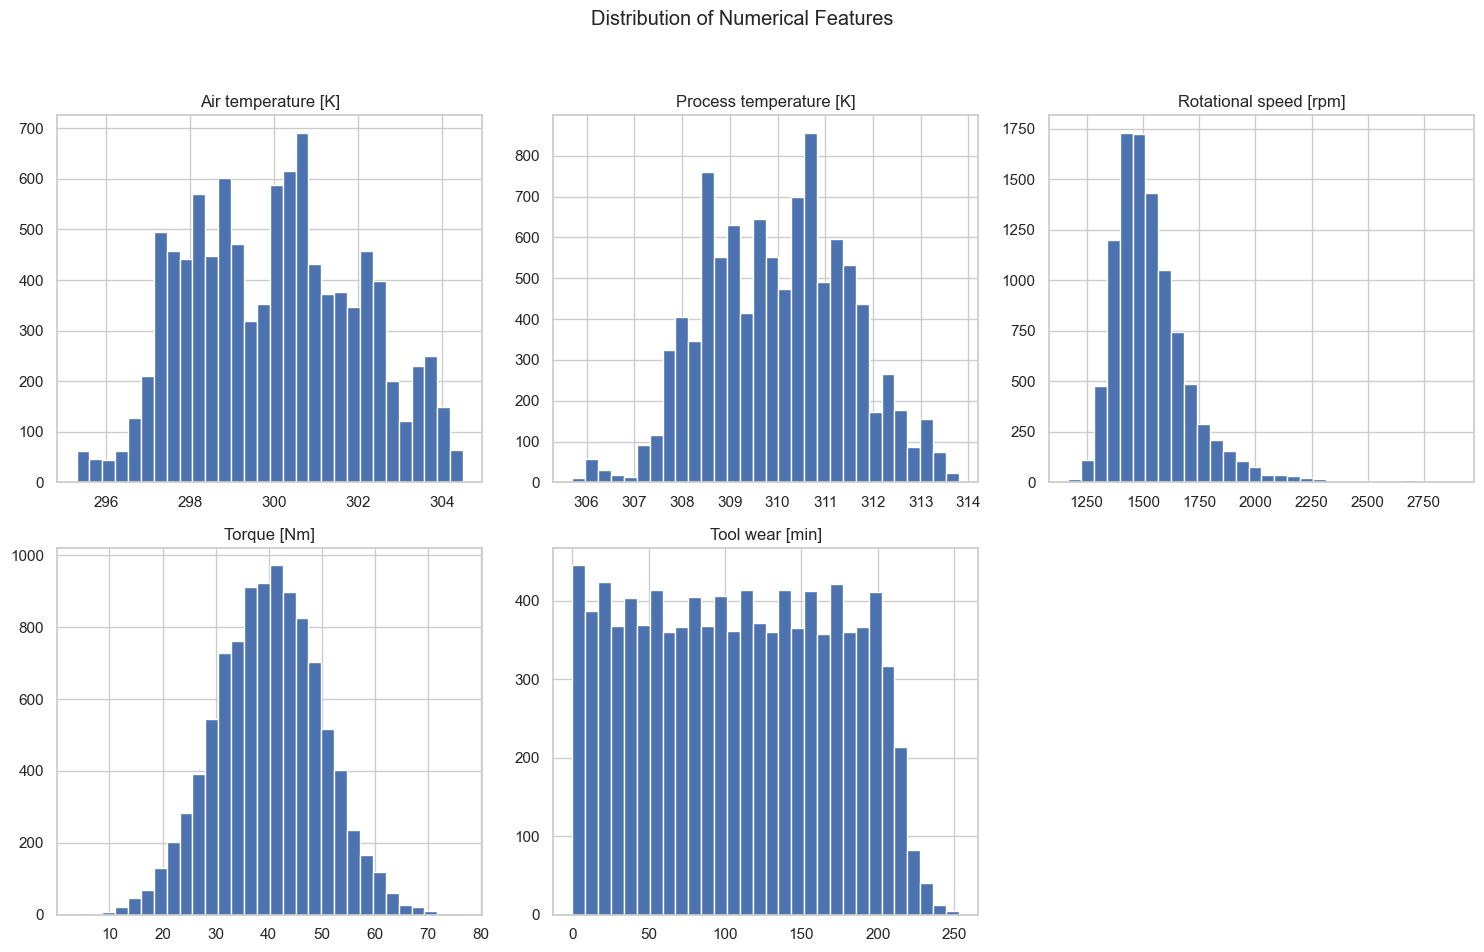


Numerical Feature Distributions by Target Variable:


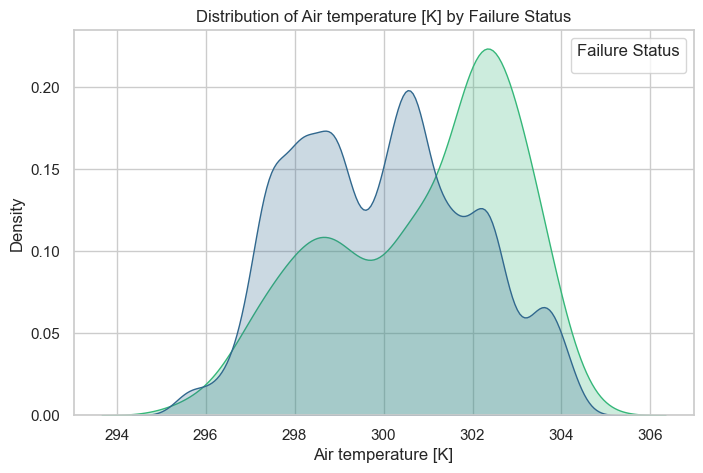

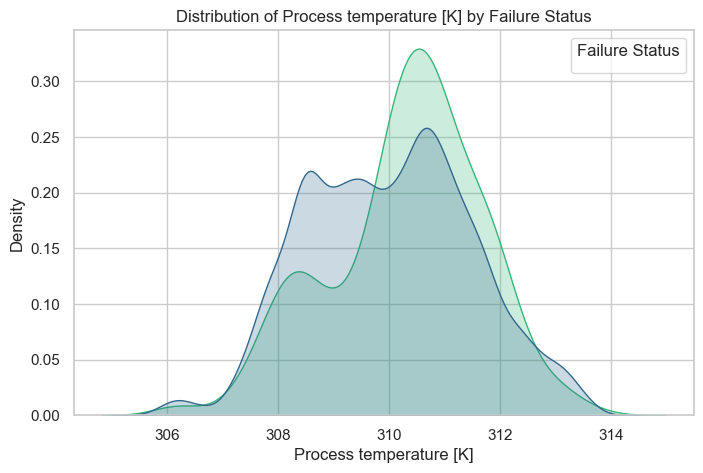

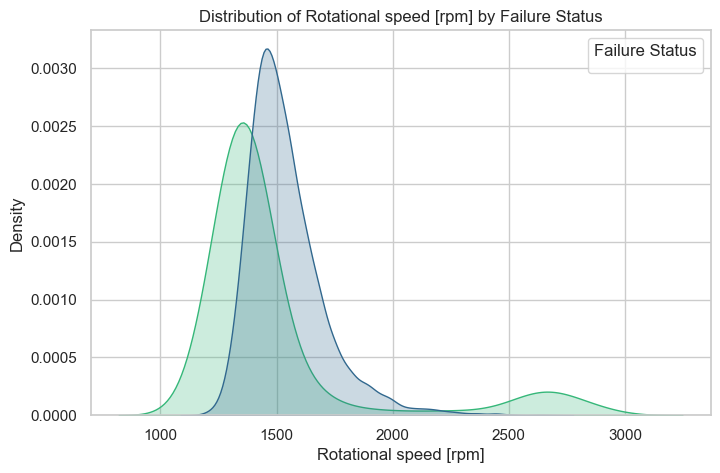

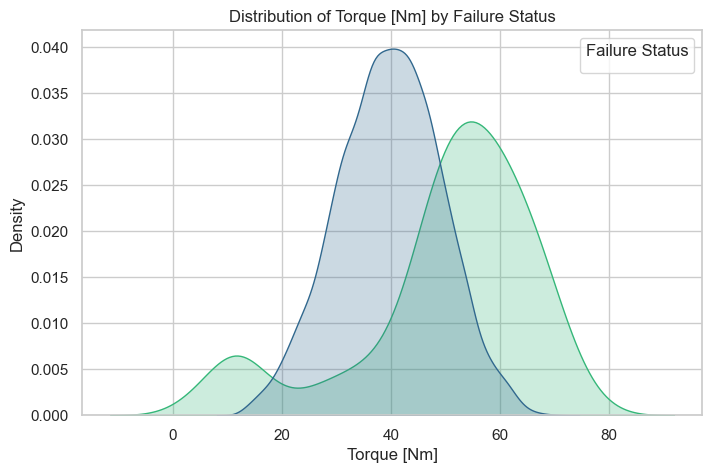

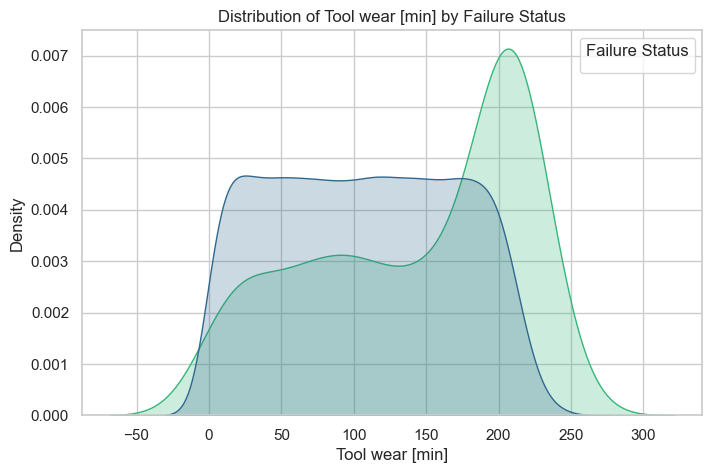

In [6]:
# Separate numerical and categorical columns
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

# Plot histograms for numerical features
print("Histograms of Numerical Features:")
df[numerical_features].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot distributions grouped by Target variable
print("\nNumerical Feature Distributions by Target Variable:")
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=col, hue='Target', fill=True, common_norm=False, palette='viridis')
    plt.title(f'Distribution of {col} by Failure Status')
    # Get current legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    # Assuming hue maps 0 to first label, 1 to second:
    plt.legend(handles, ['No Failure (0)', 'Failure (1)'], title='Failure Status')
    plt.show()

**Numerical Feature Distribution Insights:** Temperatures slightly higher for failures. Speed shows failures concentrated at lower speeds and a distinct high-speed cluster. Torque shows failures concentrated at high values and a smaller low-torque/high-speed cluster. Tool Wear failures clearly linked to high wear values.

### 4.4 Categorical Feature Analysis (`Type`)

Distribution of Machine Type:
Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


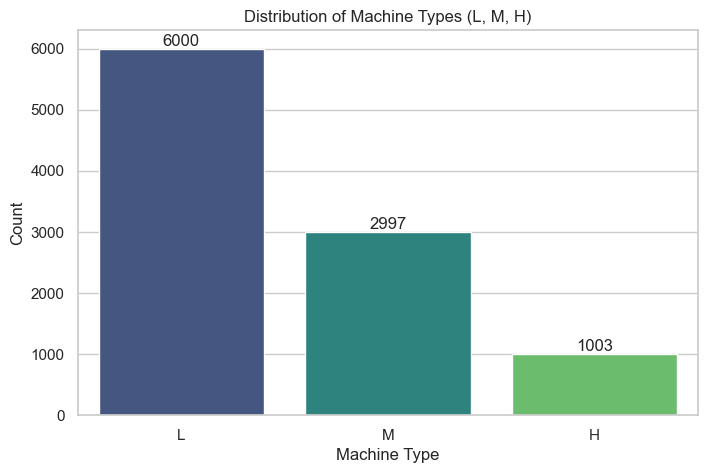

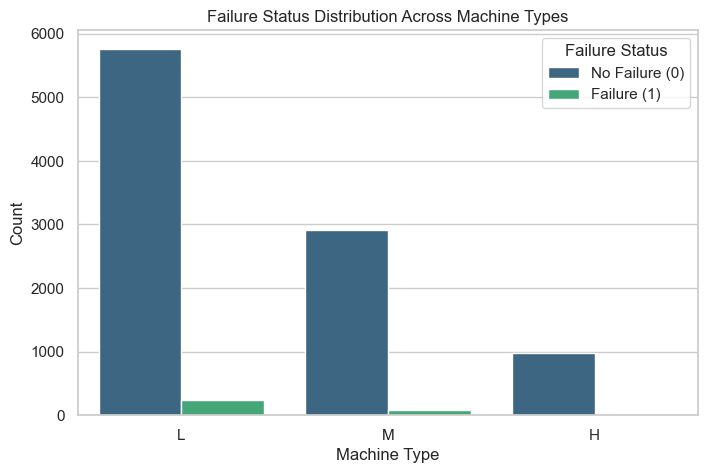


Failure Rate (%) per Machine Type:
Type
H    2.093719
L    3.916667
M    2.769436
Name: Target, dtype: float64


In [7]:
print("Distribution of Machine Type:")
type_counts = df['Type'].value_counts()
print(type_counts)

plt.figure(figsize=(8, 5))
sns.countplot(x='Type', data=df, order=type_counts.index, palette='viridis') # Added palette
plt.title('Distribution of Machine Types (L, M, H)')
plt.xlabel('Machine Type')
plt.ylabel('Count')
for index, value in enumerate(type_counts):
    plt.text(index, value + 50, str(value), ha='center')
plt.show()

# Relationship between Type and Target
plt.figure(figsize=(8, 5))
sns.countplot(x='Type', hue='Target', data=df, order=['L', 'M', 'H'], palette='viridis') # Added palette
plt.title('Failure Status Distribution Across Machine Types')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.legend(title='Failure Status', labels=['No Failure (0)', 'Failure (1)'])
plt.show()

# Calculate failure rate per type
failure_rate = df.groupby('Type')['Target'].mean() * 100
print("\nFailure Rate (%) per Machine Type:")
print(failure_rate)

**Categorical Feature Insights:** Type 'L' most common. Failure rates are somewhat similar across types (L: 3.92%, M: 2.77%, H: 2.09%), with 'L' slightly higher.

### 4.5 Correlation Analysis

Correlation Matrix (Numerical Features + Target):


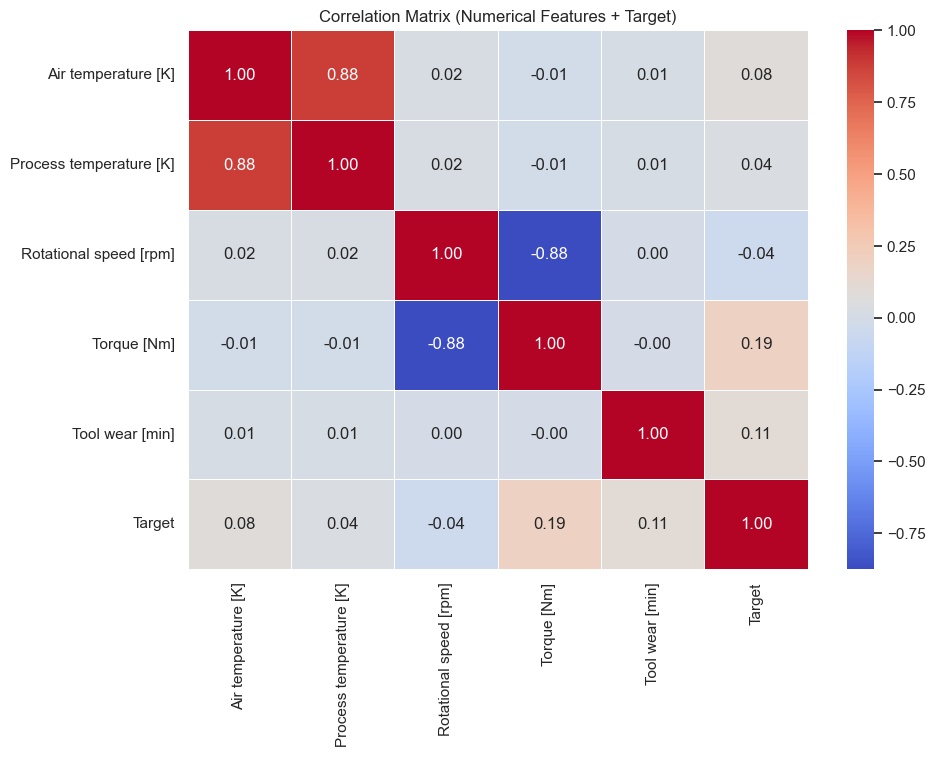

In [8]:
# Re-run preprocessing steps just to get df_processed if needed
df_processed_corr = df.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)
numerical_cols_corr = df_processed_corr.select_dtypes(include=np.number).columns.tolist()

print("Correlation Matrix (Numerical Features + Target):")
correlation_matrix_full = df_processed_corr[numerical_cols_corr].corr() # Includes Target

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix_full, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix (Numerical Features + Target)')
plt.show()

**Correlation Insights (Including Target):**
*   **Feature-Feature Correlations:** As noted before, strong positive correlation between temperatures (0.88) and strong negative between Speed/Torque (-0.88).
*   **Feature-Target Correlations:**
    *   `Torque` shows the strongest positive correlation with `Target` (0.19). Higher torque is associated with failure.
    *   `Tool wear` also has a positive correlation (0.11). Higher wear is associated with failure.
    *   `Rotational speed` has a slight negative correlation (-0.04), suggesting very marginally lower speeds might be linked to failure overall, but this is weak and likely masked by the different failure modes seen in distribution plots.
    *   Temperatures have very weak positive correlations (0.08) with the target.
*   These low-to-moderate correlations suggest that predicting failure likely requires combinations of features rather than relying heavily on any single sensor reading.

### 4.6 Pair Plot Analysis

Generating Pair Plot (colored by Target)...


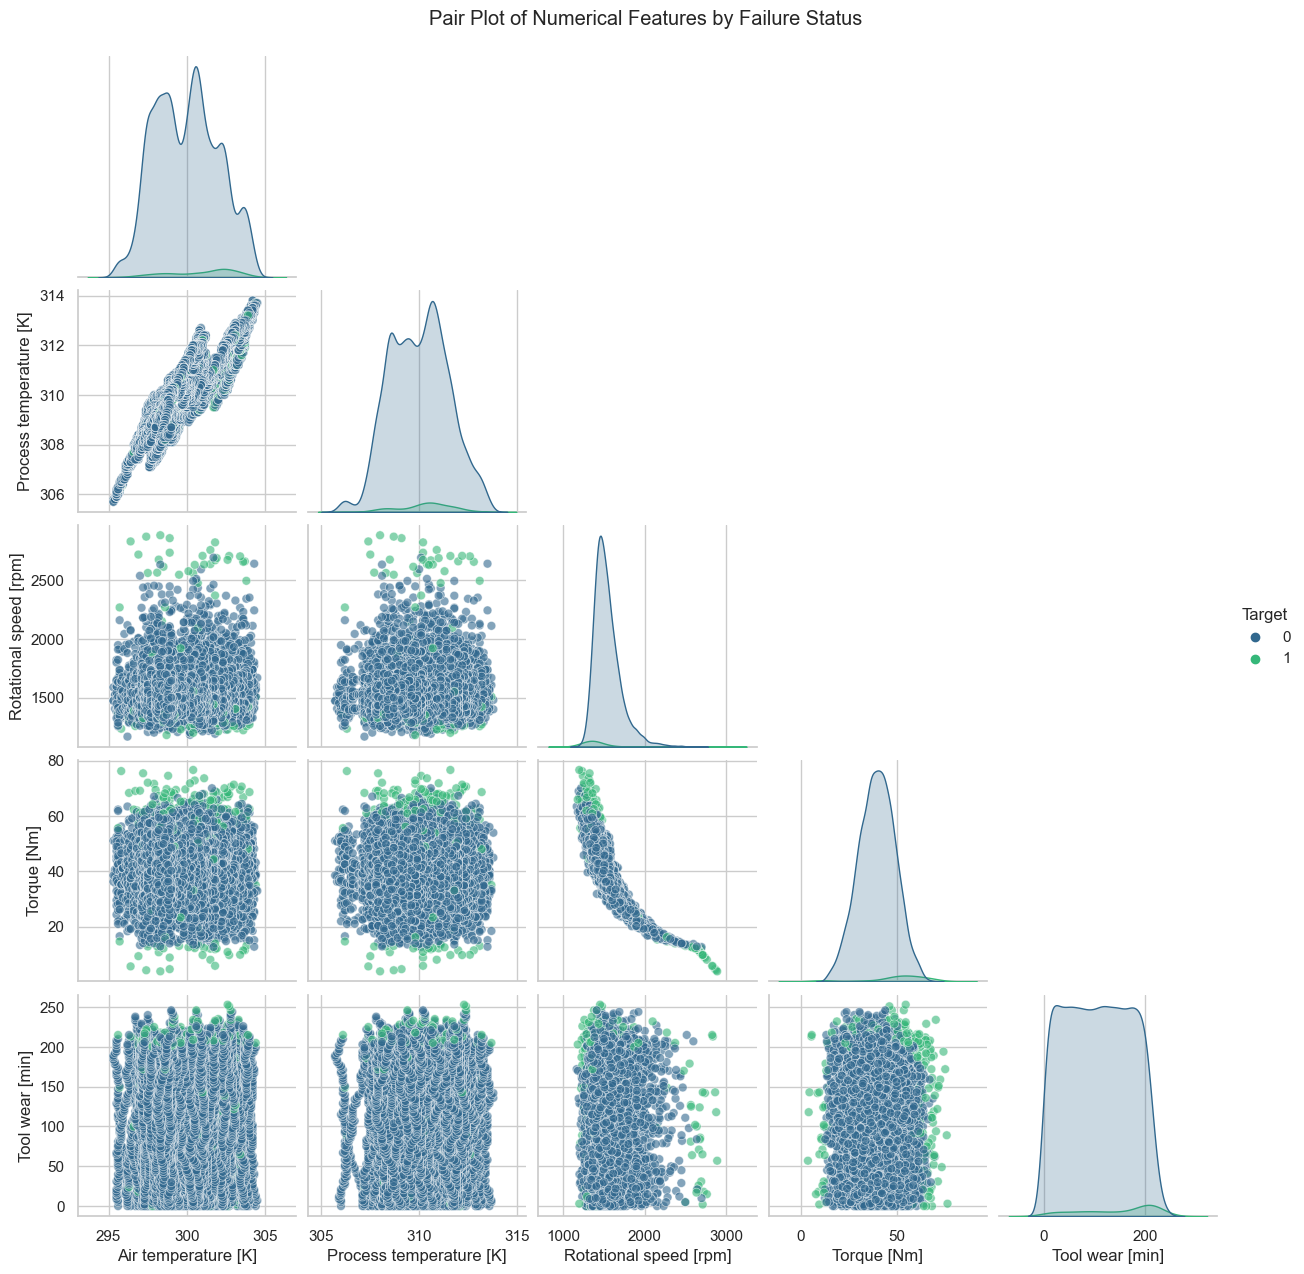

In [9]:
print("Generating Pair Plot (colored by Target)...")
pairplot_df = df[numerical_features + ['Target']]
sns.pairplot(pairplot_df, hue='Target', diag_kind='kde', palette='viridis', plot_kws={'alpha': 0.6, 's': 40}, corner=True) # Adjusted point size
plt.suptitle('Pair Plot of Numerical Features by Failure Status', y=1.02)
plt.show()

**Pair Plot Insights:** Visually confirms failure clusters (high torque/low speed, high tool wear, high speed/low torque). Significant class overlap highlights the modeling challenge.

## 5. Data Preprocessing Pipeline Setup

Define the `ColumnTransformer` to apply scaling and encoding consistently.

In [10]:
# Drop unnecessary columns (if not already done)
df_processed = df.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)

# Define features (X) and target (y)
X = df_processed.drop('Target', axis=1)
y = df_processed['Target']

# Identify column names again (safe practice)
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False) # Ensure dense output

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

print("\nPreprocessor (ColumnTransformer) configured.")
from sklearn import set_config
set_config(display='diagram')
display(preprocessor)
set_config(display='text') # Reset


Numerical columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Categorical columns: ['Type']

Preprocessor (ColumnTransformer) configured.


ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Air temperature [K]',
                                  'Process temperature [K]',
                                  'Rotational speed [rpm]', 'Torque [Nm]',
                                  'Tool wear [min]']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Type'])])

**Preprocessing Summary:** `StandardScaler` for numerical, `OneHotEncoder` (dropping first category) for categorical, bundled in `preprocessor`.

## 6. Modeling Setup

Define models, hyperparameter grids, metrics, and CV strategy.

In [11]:
# Define Models
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
svm_model = SVC(random_state=42, probability=True, class_weight='balanced', cache_size=500) # Added cache_size

# Define Hyperparameter Grids
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 3]
}

param_grid_svm = {
    'model__C': [1, 10, 100],
    'model__gamma': ['scale', 0.1, 0.01],
    'model__kernel': ['rbf'] # Focusing on RBF kernel for potentially better performance and reduced grid size
    # 'model__kernel': ['rbf', 'linear'] # Uncomment to include linear kernel
}

# Define evaluation metrics dictionary
metrics_dict = {
    'Accuracy': accuracy_score,
    'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
    'Recall': recall_score,
    'F1': f1_score,
    'ROC_AUC': roc_auc_score
}

# Store results and best model info
results = {}
best_models_info = {}

# Define Stratified K-Fold for cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Models, hyperparameter grids, and evaluation setup complete.")

Models, hyperparameter grids, and evaluation setup complete.


In [12]:
# Define the evaluation helper function (includes timing and ROC curve)
def evaluate_model(model_name, scenario_name, model, X_test_eval, y_test_eval, results_dict):
    """Calculates and stores evaluation metrics for a given model and test set."""
    print(f"--- Evaluating {model_name} ({scenario_name}) ---")
    start_time = time.time()
    y_pred = model.predict(X_test_eval)

    y_prob = None
    roc_auc = np.nan
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_eval)[:, 1]
            roc_auc = roc_auc_score(y_test_eval, y_prob)
        else:
            # Fallback for models without predict_proba if needed (though both RF/SVC should have it)
             if hasattr(model, "decision_function"):
                 y_decision = model.decision_function(X_test_eval)
                 roc_auc = roc_auc_score(y_test_eval, y_decision)
             else:
                 print(f"Warning: Cannot calculate ROC AUC for {model_name}, no predict_proba or decision_function.")
    except Exception as e:
         print(f"Warning: Could not calculate ROC AUC score for {model_name}. Error: {e}")


    end_time = time.time()
    inference_time = end_time - start_time

    metrics = {
        'Accuracy': accuracy_score(y_test_eval, y_pred),
        'Precision': precision_score(y_test_eval, y_pred, zero_division=0),
        'Recall': recall_score(y_test_eval, y_pred),
        'F1': f1_score(y_test_eval, y_pred),
        'ROC_AUC': roc_auc # Store calculated or NaN value
    }

    if scenario_name not in results_dict:
        results_dict[scenario_name] = {}
    results_dict[scenario_name][model_name] = metrics

    print(f"Inference Time: {inference_time:.2f} seconds")
    print(classification_report(y_test_eval, y_pred, zero_division=0))
    print(f"ROC AUC Score: {metrics['ROC_AUC']:.4f}")
    print("-" * 60)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test_eval, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig_cm, ax_cm = plt.subplots(figsize=(5, 4)) # Smaller figure size
    disp.plot(cmap=plt.cm.Blues, ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {model_name}\n({scenario_name})')
    plt.show()

    # Plot ROC Curve (if probabilities/scores available)
    fig_roc, ax_roc = plt.subplots(figsize=(6, 5))
    roc_plotted = False
    if y_prob is not None:
        try:
            RocCurveDisplay.from_predictions(y_test_eval, y_prob, ax=ax_roc, name=model_name)
            roc_plotted = True
        except Exception as roc_e:
             print(f"Could not plot ROC curve from probabilities: {roc_e}")
    elif 'y_decision' in locals(): # Check if decision function was used
         try:
             RocCurveDisplay.from_predictions(y_test_eval, y_decision, ax=ax_roc, name=model_name)
             roc_plotted = True
         except Exception as roc_e:
             print(f"Could not plot ROC curve from decision function: {roc_e}")

    if roc_plotted:
        ax_roc.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
        ax_roc.set_title(f'ROC Curve: {model_name}\n({scenario_name})')
        ax_roc.legend()
        plt.show()
    else:
        plt.close(fig_roc) # Close the empty figure if ROC wasn't plotted
        print("Skipping ROC curve plot.")

    return metrics

## 7. Modeling Scenarios

We will now implement the four scenarios, train the models with hyperparameter tuning, and evaluate their performance.

**Important Note on Resampling:** Resampling techniques (Undersampling, SMOTE, GAN) are applied **only to the training data** *after* the initial train-test split or *within* the cross-validation folds of GridSearchCV when using `imblearn.pipeline.Pipeline`. This prevents data leakage from the test set into the training process and ensures a realistic evaluation of the model's generalization performance on unseen data.

In [13]:
# --- Train-Test Split ---
# Split Data before applying any scenario-specific sampling to the training set
# Use stratification to maintain class proportions in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("--- Initial Data Split ---")
print(f"Training set shape: {X_train.shape}, Target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set shape: {X_test.shape}, Target distribution:\n{y_test.value_counts(normalize=True)}")
print("-" * 60)

--- Initial Data Split ---
Training set shape: (7000, 6), Target distribution:
Target
0    0.966143
1    0.033857
Name: proportion, dtype: float64
Test set shape: (3000, 6), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64
------------------------------------------------------------


### Scenario 1: Baseline (No Resampling)

--- Scenario 1: Baseline (No Resampling) ---

Training Random Forest (Baseline)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF ROC AUC score (CV): 0.9669
RF Tuning Time: 39.43 seconds
--- Evaluating Random Forest (Baseline) ---
Inference Time: 0.14 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2898
           1       0.62      0.67      0.64       102

    accuracy                           0.97      3000
   macro avg       0.81      0.83      0.82      3000
weighted avg       0.98      0.97      0.98      3000

ROC AUC Score: 0.9767
------------------------------------------------------------


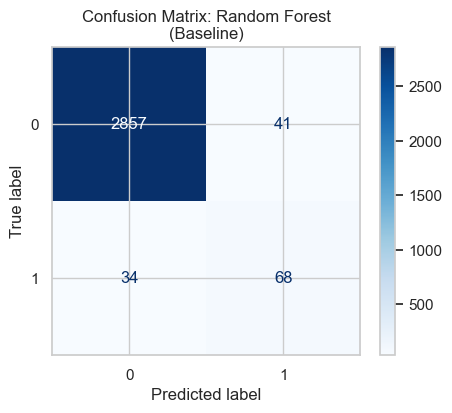

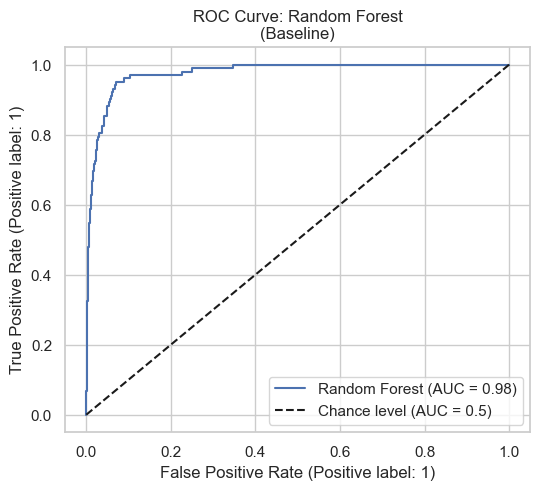


Training SVM (Baseline)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVM parameters: {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best SVM ROC AUC score (CV): 0.9568
SVM Tuning Time: 26.44 seconds
--- Evaluating SVM (Baseline) ---
Inference Time: 0.91 seconds
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2898
           1       0.27      0.91      0.41       102

    accuracy                           0.91      3000
   macro avg       0.63      0.91      0.68      3000
weighted avg       0.97      0.91      0.93      3000

ROC AUC Score: 0.9691
------------------------------------------------------------


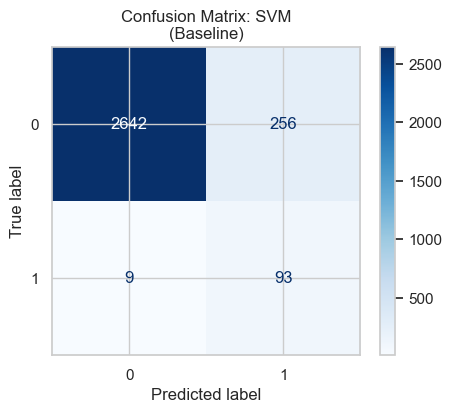

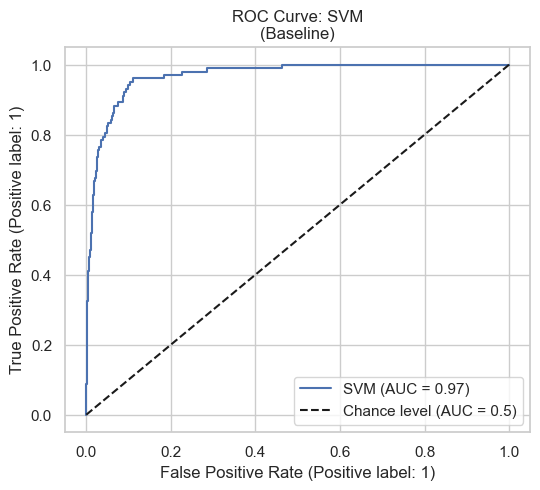

{'Accuracy': 0.9116666666666666,
 'Precision': 0.2664756446991404,
 'Recall': 0.9117647058823529,
 'F1': 0.4124168514412417,
 'ROC_AUC': 0.9691470791215037}

In [14]:
print("--- Scenario 1: Baseline (No Resampling) ---")
scenario = 'Baseline'
best_models_info[scenario] = {}

# --- Random Forest ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
start_tune_time = time.time()
pipeline_rf_base = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model) # rf_model already includes class_weight='balanced'
])
grid_search_rf_base = GridSearchCV(pipeline_rf_base, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_base.fit(X_train, y_train)
end_tune_time = time.time()
best_models_info[scenario][model_name_rf] = {
    'model': grid_search_rf_base.best_estimator_,
    'best_score_cv': grid_search_rf_base.best_score_,
    'best_params': grid_search_rf_base.best_params_,
    'tune_time': end_tune_time - start_tune_time
}
print(f"Best RF parameters: {grid_search_rf_base.best_params_}")
print(f"Best RF ROC AUC score (CV): {grid_search_rf_base.best_score_:.4f}")
print(f"RF Tuning Time: {best_models_info[scenario][model_name_rf]['tune_time']:.2f} seconds")
# Evaluate RF
evaluate_model(model_name_rf, scenario, best_models_info[scenario][model_name_rf]['model'], X_test, y_test, results)


# --- SVM ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
start_tune_time = time.time()
pipeline_svm_base = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svm_model) # svm_model already includes class_weight='balanced'
])
grid_search_svm_base = GridSearchCV(pipeline_svm_base, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_base.fit(X_train, y_train)
end_tune_time = time.time()
best_models_info[scenario][model_name_svm] = {
    'model': grid_search_svm_base.best_estimator_,
    'best_score_cv': grid_search_svm_base.best_score_,
    'best_params': grid_search_svm_base.best_params_,
    'tune_time': end_tune_time - start_tune_time
}
print(f"Best SVM parameters: {grid_search_svm_base.best_params_}")
print(f"Best SVM ROC AUC score (CV): {grid_search_svm_base.best_score_:.4f}")
print(f"SVM Tuning Time: {best_models_info[scenario][model_name_svm]['tune_time']:.2f} seconds")
# Evaluate SVM
evaluate_model(model_name_svm, scenario, best_models_info[scenario][model_name_svm]['model'], X_test, y_test, results)

**Baseline Scenario Explanation:**
*   The initial `train_test_split` created our training and test sets, preserving the original imbalance via `stratify=y`.
*   Standard `sklearn.pipeline.Pipeline` objects are used. The pipeline first applies the `preprocessor` (StandardScaler + OneHotEncoder) to the data fed into it, and then trains the specified model (`rf_model` or `svm_model`).
*   The models themselves include `class_weight='balanced'`, which provides a baseline level of imbalance handling by adjusting sample weights during training.
*   `GridSearchCV` optimizes hyperparameters using 5-fold stratified cross-validation (`cv_stratified`) on the *training set*. It selects the best parameters based on the average `roc_auc` score across the folds. `n_jobs=-1` utilizes all available CPU cores for faster tuning.
*   The final, best model (retrained on the full training set using the best parameters) is evaluated on the *untouched test set*. Metrics and confusion matrices show performance on unseen, imbalanced data. Tuning and inference times are also recorded.

### Scenario 2: Random Undersampling (RUS)

Balance the training data by randomly removing majority class samples. Uses `imblearn.pipeline.Pipeline` to apply RUS within each cross-validation fold during tuning.


--- Scenario 2: Random Undersampling (RUS) ---

Training Random Forest (Random Undersampling)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF parameters (RUS): {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best RF ROC AUC score (CV with RUS): 0.9579
RF Tuning Time: 12.53 seconds
--- Evaluating Random Forest (Random Undersampling) ---
Inference Time: 0.10 seconds
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2898
           1       0.23      0.93      0.37       102

    accuracy                           0.89      3000
   macro avg       0.62      0.91      0.66      3000
weighted avg       0.97      0.89      0.92      3000

ROC AUC Score: 0.9563
------------------------------------------------------------


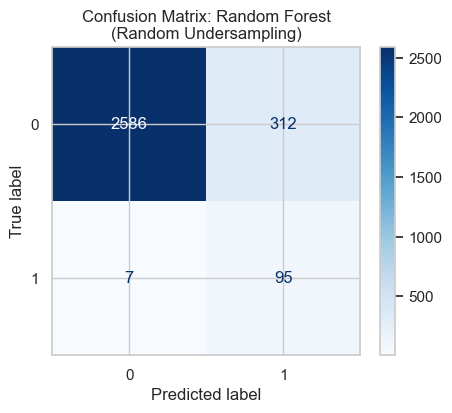

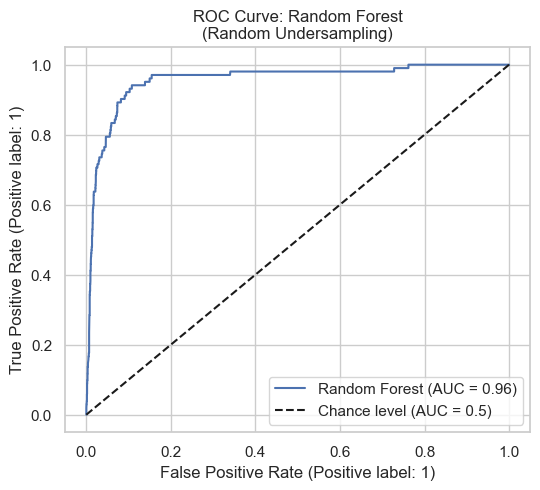


Training SVM (Random Undersampling)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVM parameters (RUS): {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best SVM ROC AUC score (CV with RUS): 0.9523
SVM Tuning Time: 0.63 seconds
--- Evaluating SVM (Random Undersampling) ---
Inference Time: 0.08 seconds
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2898
           1       0.23      0.93      0.37       102

    accuracy                           0.89      3000
   macro avg       0.62      0.91      0.66      3000
weighted avg       0.97      0.89      0.92      3000

ROC AUC Score: 0.9657
------------------------------------------------------------


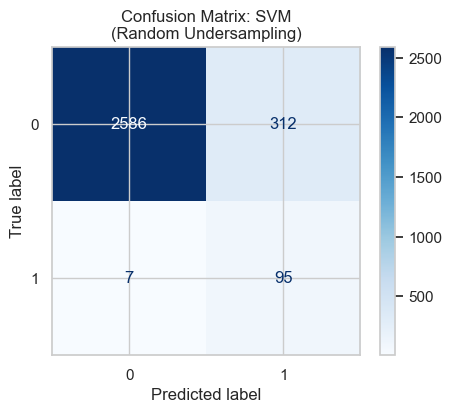

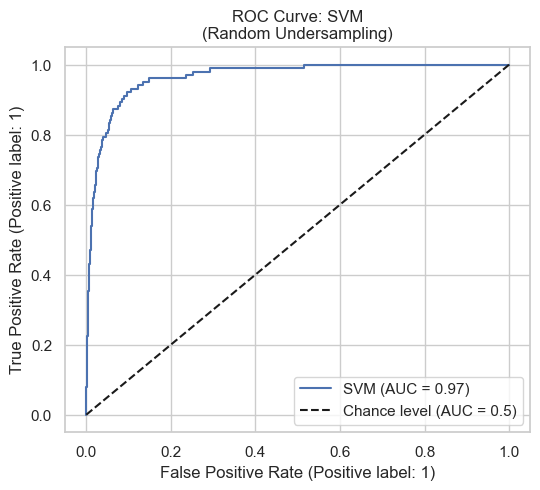

{'Accuracy': 0.8936666666666667,
 'Precision': 0.2334152334152334,
 'Recall': 0.9313725490196079,
 'F1': 0.3732809430255402,
 'ROC_AUC': 0.9656592105441211}

In [15]:
print("\n--- Scenario 2: Random Undersampling (RUS) ---")
scenario = 'Random Undersampling'
best_models_info[scenario] = {}

# Define the undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42) # 'auto' balances to match minority

# --- Random Forest with RUS ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
start_tune_time = time.time()
pipeline_rf_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', rus), # Renamed step to 'sampler'
    ('model', rf_model)
])
# Grid parameters need to target the 'model' step in the ImbPipeline
grid_search_rf_rus = GridSearchCV(pipeline_rf_rus, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_rus.fit(X_train, y_train)
end_tune_time = time.time()
best_models_info[scenario][model_name_rf] = {
    'model': grid_search_rf_rus.best_estimator_,
    'best_score_cv': grid_search_rf_rus.best_score_,
    'best_params': grid_search_rf_rus.best_params_,
    'tune_time': end_tune_time - start_tune_time
}
print(f"Best RF parameters (RUS): {grid_search_rf_rus.best_params_}")
print(f"Best RF ROC AUC score (CV with RUS): {grid_search_rf_rus.best_score_:.4f}")
print(f"RF Tuning Time: {best_models_info[scenario][model_name_rf]['tune_time']:.2f} seconds")
# Evaluate RF on the original TEST set
evaluate_model(model_name_rf, scenario, best_models_info[scenario][model_name_rf]['model'], X_test, y_test, results)


# --- SVM with RUS ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
start_tune_time = time.time()
pipeline_svm_rus = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', rus), # Renamed step to 'sampler'
    ('model', svm_model)
])
grid_search_svm_rus = GridSearchCV(pipeline_svm_rus, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_rus.fit(X_train, y_train)
end_tune_time = time.time()
best_models_info[scenario][model_name_svm] = {
    'model': grid_search_svm_rus.best_estimator_,
    'best_score_cv': grid_search_svm_rus.best_score_,
    'best_params': grid_search_svm_rus.best_params_,
    'tune_time': end_tune_time - start_tune_time
}
print(f"Best SVM parameters (RUS): {grid_search_svm_rus.best_params_}")
print(f"Best SVM ROC AUC score (CV with RUS): {grid_search_svm_rus.best_score_:.4f}")
print(f"SVM Tuning Time: {best_models_info[scenario][model_name_svm]['tune_time']:.2f} seconds")
# Evaluate SVM on the original TEST set
evaluate_model(model_name_svm, scenario, best_models_info[scenario][model_name_svm]['model'], X_test, y_test, results)

**Random Undersampling Explanation:**
*   `RandomUnderSampler` is configured with `sampling_strategy='auto'` (default) to reduce the majority class size to match the minority class size.
*   The key difference from the baseline is using `imblearn.pipeline.Pipeline`. This special pipeline ensures that the `sampler` step (RUS) is executed *after* the `preprocessor` but *before* the `model` step, and importantly, this resampling is applied *only* to the training portion within *each* cross-validation fold during the `GridSearchCV` process. This prevents data leakage between folds and provides a more accurate assessment of how the model will generalize when trained on undersampled data.
*   The final best model is retrained using the optimal hyperparameters on the entire `X_train` dataset, applying RUS just before the final model training.
*   Evaluation occurs on the original, untouched `X_test`. We anticipate potentially higher Recall but possibly lower Precision/Accuracy compared to the baseline due to information loss from the majority class.

### Scenario 3: SMOTE Oversampling

Balance the training data by synthetically generating minority class samples using SMOTE. Uses `imblearn.pipeline.Pipeline`.


--- Scenario 3: SMOTE Oversampling ---

Training Random Forest (SMOTE Oversampling)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF parameters (SMOTE): {'model__max_depth': 20, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF ROC AUC score (CV with SMOTE): 0.9656
RF Tuning Time: 50.27 seconds
--- Evaluating Random Forest (SMOTE Oversampling) ---
Inference Time: 0.16 seconds
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2898
           1       0.47      0.75      0.58       102

    accuracy                           0.96      3000
   macro avg       0.73      0.86      0.78      3000
weighted avg       0.97      0.96      0.97      3000

ROC AUC Score: 0.9734
------------------------------------------------------------


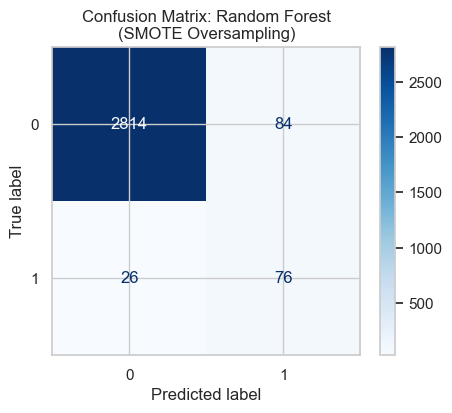

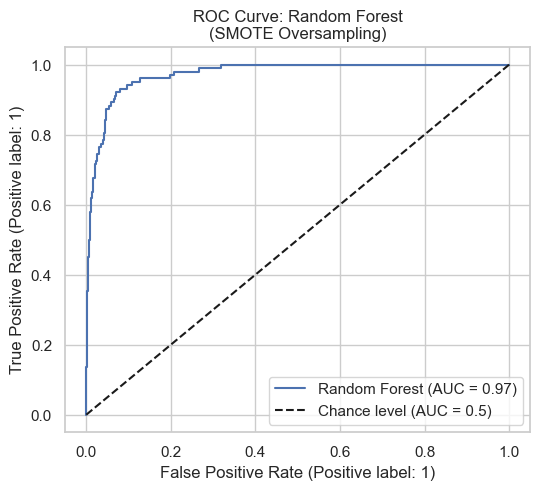


Training SVM (SMOTE Oversampling)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVM parameters (SMOTE): {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best SVM ROC AUC score (CV with SMOTE): 0.9553
SVM Tuning Time: 88.89 seconds
--- Evaluating SVM (SMOTE Oversampling) ---
Inference Time: 1.50 seconds
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2898
           1       0.29      0.92      0.44       102

    accuracy                           0.92      3000
   macro avg       0.64      0.92      0.70      3000
weighted avg       0.97      0.92      0.94      3000

ROC AUC Score: 0.9698
------------------------------------------------------------


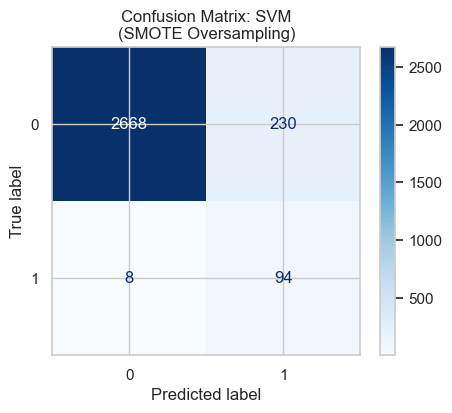

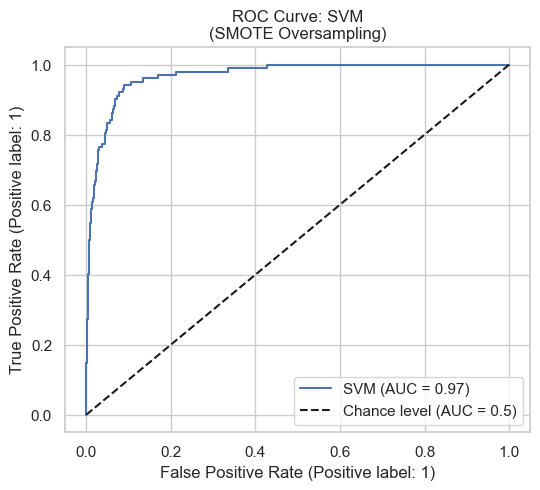

{'Accuracy': 0.9206666666666666,
 'Precision': 0.29012345679012347,
 'Recall': 0.9215686274509803,
 'F1': 0.44131455399061037,
 'ROC_AUC': 0.969833827250707}

In [16]:
print("\n--- Scenario 3: SMOTE Oversampling ---")
scenario = 'SMOTE Oversampling'
best_models_info[scenario] = {}

# Define the SMOTE sampler
# k_neighbors=5 is a common default, defines neighbors used to generate synthetic samples.
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=-1)

# --- Random Forest with SMOTE ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
start_tune_time = time.time()
pipeline_rf_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', smote), # Renamed step to 'sampler'
    ('model', rf_model)
])
grid_search_rf_smote = GridSearchCV(pipeline_rf_smote, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_smote.fit(X_train, y_train)
end_tune_time = time.time()
best_models_info[scenario][model_name_rf] = {
    'model': grid_search_rf_smote.best_estimator_,
    'best_score_cv': grid_search_rf_smote.best_score_,
    'best_params': grid_search_rf_smote.best_params_,
    'tune_time': end_tune_time - start_tune_time
}
print(f"Best RF parameters (SMOTE): {grid_search_rf_smote.best_params_}")
print(f"Best RF ROC AUC score (CV with SMOTE): {grid_search_rf_smote.best_score_:.4f}")
print(f"RF Tuning Time: {best_models_info[scenario][model_name_rf]['tune_time']:.2f} seconds")
# Evaluate RF on the original TEST set
evaluate_model(model_name_rf, scenario, best_models_info[scenario][model_name_rf]['model'], X_test, y_test, results)


# --- SVM with SMOTE ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
start_tune_time = time.time()
pipeline_svm_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', smote), # Renamed step to 'sampler'
    ('model', svm_model)
])
grid_search_svm_smote = GridSearchCV(pipeline_svm_smote, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_smote.fit(X_train, y_train)
end_tune_time = time.time()
best_models_info[scenario][model_name_svm] = {
    'model': grid_search_svm_smote.best_estimator_,
    'best_score_cv': grid_search_svm_smote.best_score_,
    'best_params': grid_search_svm_smote.best_params_,
    'tune_time': end_tune_time - start_tune_time
}
print(f"Best SVM parameters (SMOTE): {grid_search_svm_smote.best_params_}")
print(f"Best SVM ROC AUC score (CV with SMOTE): {grid_search_svm_smote.best_score_:.4f}")
print(f"SVM Tuning Time: {best_models_info[scenario][model_name_svm]['tune_time']:.2f} seconds")
# Evaluate SVM on the original TEST set
evaluate_model(model_name_svm, scenario, best_models_info[scenario][model_name_svm]['model'], X_test, y_test, results)

**SMOTE Oversampling Explanation:**
*   `SMOTE` (Synthetic Minority Over-sampling Technique) is used to generate artificial minority class samples. `sampling_strategy='auto'` increases the minority class size to match the majority class. `k_neighbors=5` specifies that 5 nearest minority class neighbors are used to interpolate new synthetic samples. `n_jobs=-1` allows SMOTE to use multiple cores if its implementation supports it.
*   As with RUS, SMOTE is placed within an `imblearn.pipeline.Pipeline` immediately following the preprocessing step and before the model training step. This ensures correct application during cross-validation within `GridSearchCV`, preventing data leakage and providing reliable hyperparameter tuning based on data resampled within each fold.
*   The final model uses the best parameters found and is trained on the full `X_train` data, with SMOTE applied just before model training.
*   Evaluation is performed on the original, untouched `X_test`. SMOTE aims to improve Recall and F1-score by boosting the minority class representation, typically without the information loss associated with undersampling.

### Scenario 4: GAN Oversampling (TabGAN)

Generate synthetic minority samples using the TabGAN library, which implements a GAN variant suitable for tabular data. GPU acceleration is used if available and PyTorch with CUDA is installed.

**Process:**
1.  Initialize `tabgan.GANGenerator`. GPU is used automatically if PyTorch detects a CUDA device.
2.  Use `generate_data_pipe` on the **original** `X_train`, `y_train`. This method internally handles training the GAN and generating augmented data. `X_test` is passed to help match the target distribution but is not used for training.
3.  The method returns `X_train_aug`, `y_train_aug` which combine original and synthetic samples in the **original feature space**.
4.  Train the RF and SVM models (with `GridSearchCV`) using pipelines that **include the preprocessing step**, as the augmented data needs to be preprocessed before modeling.
5.  Evaluate on the original `X_test` (using the full pipeline including preprocessing).


--- Scenario 4: GAN Oversampling (TabGAN) ---
Minority class label: 1
Majority class label: 0
Original training set: 7000 samples
Original minority samples: 237
Original majority samples: 6763
Need to generate 6526 synthetic minority samples.
Calculated gen_x_times for TabGAN: 27.5359
Initializing TabGAN Generator (GPU available via PyTorch: True)...
Starting TabGAN data generation for minority class (this may take time)...


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/50 [00:00<?, ?it/s]

TabGAN minority generation complete. Time: 9.94 seconds
Generated 2290 synthetic minority samples.
Augmented training data shape: (9290, 6)
Augmented target distribution:
Target
0    0.75662
1    0.24338
Name: proportion, dtype: float64

Training Random Forest (GAN Oversampling)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF parameters (TabGAN): {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF ROC AUC score (CV with TabGAN): 0.9718
RF Tuning Time: 31.30 seconds
--- Evaluating Random Forest (GAN Oversampling) ---
Inference Time: 0.15 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2898
           1       0.69      0.60      0.64       102

    accuracy                           0.98      3000
   macro avg       0.84      0.79      0.81      3000
weighted avg       0.98      0.98      0.98      3000

ROC AUC Score: 0.9633
-----

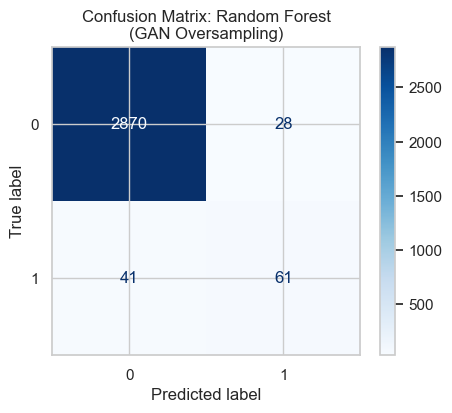

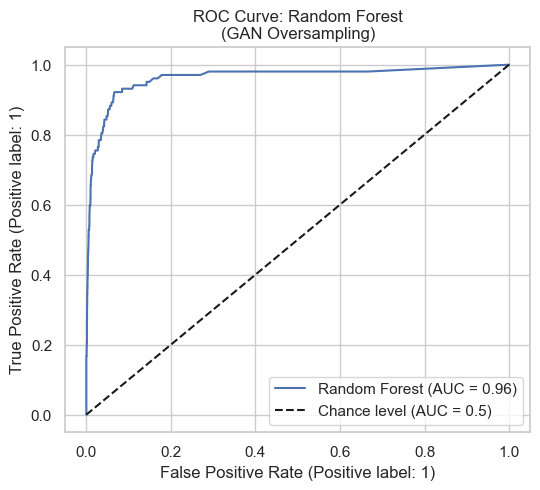


Training SVM (GAN Oversampling)...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVM parameters (TabGAN): {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best SVM ROC AUC score (CV with TabGAN): 0.9709
SVM Tuning Time: 49.22 seconds
--- Evaluating SVM (GAN Oversampling) ---
Inference Time: 0.82 seconds
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2898
           1       0.47      0.73      0.57       102

    accuracy                           0.96      3000
   macro avg       0.73      0.85      0.78      3000
weighted avg       0.97      0.96      0.97      3000

ROC AUC Score: 0.9661
------------------------------------------------------------


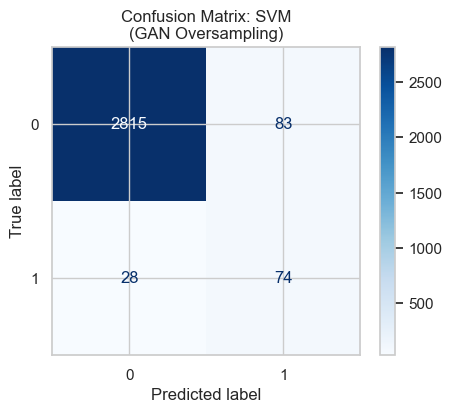

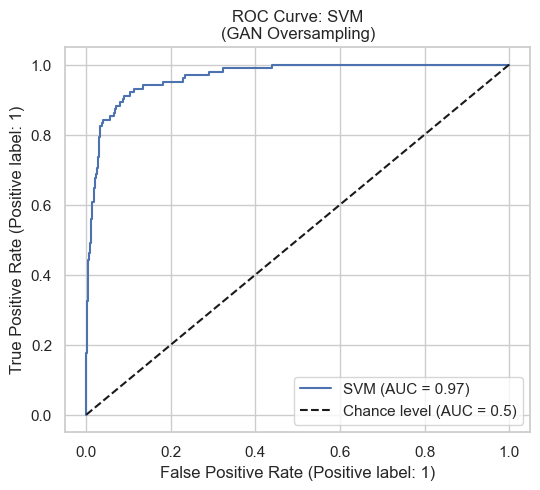

In [17]:
# Cell for Scenario 4: GAN Oversampling (TabGAN) - MODIFIED FOR MINORITY OVERSAMPLING

print("\n--- Scenario 4: GAN Oversampling (TabGAN) ---")
scenario = 'GAN Oversampling'
best_models_info[scenario] = {}

if not GAN_AVAILABLE or not PYTORCH_AVAILABLE:
    print(f"{scenario} skipped: TabGAN/PyTorch not available.")
    # Ensure results dict has entries for skipped scenario for consistent table later
    results[scenario] = {
        'Random Forest': {m: np.nan for m in metrics_dict.keys()}, # Use keys from metrics_dict
        'SVM': {m: np.nan for m in metrics_dict.keys()}
    }
else:
    try:
        # 1. Identify minority and majority classes from y_train
        minority_label = y_train.value_counts().idxmin()
        majority_label = y_train.value_counts().idxmax()

        print(f"Minority class label: {minority_label}")
        print(f"Majority class label: {majority_label}")

        # 2. Split original training data into minority and majority sets
        X_train_minority = X_train[y_train == minority_label]
        y_train_minority = y_train[y_train == minority_label]
        X_train_majority = X_train[y_train == majority_label]
        y_train_majority = y_train[y_train == majority_label]

        num_minority_original = len(y_train_minority)
        num_majority_original = len(y_train_majority)
        
        print(f"Original training set: {len(X_train)} samples")
        print(f"Original minority samples: {num_minority_original}")
        print(f"Original majority samples: {num_majority_original}")

        # 3. Determine number of synthetic samples needed to balance (match majority count)
        num_synthetic_needed = num_majority_original - num_minority_original

        if num_synthetic_needed > 0 and num_minority_original > 0:
            gan_gen_x_times = num_synthetic_needed / num_minority_original
            print(f"Need to generate {num_synthetic_needed} synthetic minority samples.")
            print(f"Calculated gen_x_times for TabGAN: {gan_gen_x_times:.4f}")

            # 4. Initialize TabGAN Generator to be trained only on minority data
            # categorical_cols is defined globally from the full X dataset
            print(f"Initializing TabGAN Generator (GPU available via PyTorch: {gpu_available_for_tabgan})...")
            tabgan_minority_sampler = GANGenerator(
                gen_x_times=gan_gen_x_times, 
                cat_cols=categorical_cols, # Defined in cell 18051217-4552-4f03-971f-5f6144f52a31
                # gen_params can be fine-tuned, e.g., for smaller minority set:
                # gen_params={"batch_size": max(10, num_minority_original // 10), "epochs": 100}, # Ensure batch_size is reasonable
                is_post_process=True # Default, can be experimented with
            )

            # Prepare y_train_minority as a DataFrame for TabGAN
            y_train_minority_df = y_train_minority.to_frame(name='Target')

            print(f"Starting TabGAN data generation for minority class (this may take time)...")
            start_gan_time = time.time()
            
            # ---!!! FIX: Disable adversarial filtering as per original notebook's finding !!!---
            # Train GAN on minority data and generate only synthetic samples
            X_synthetic_minority, y_synthetic_minority_df = tabgan_minority_sampler.generate_data_pipe(
                train_df=X_train_minority,
                target=y_train_minority_df,
                test_df=X_test, # test_df guides generation; using X_test as in original logic
                                # Alternatively, X_train_minority could be used if generation should only mimic observed minority
                use_adversarial=False, # Keeping user's fix
                only_generated_data=True # CRUCIAL: Get only synthetic samples
            )
            end_gan_time = time.time()
            print(f"TabGAN minority generation complete. Time: {end_gan_time - start_gan_time:.2f} seconds")
            print(f"Generated {len(X_synthetic_minority)} synthetic minority samples.")

            # Convert synthetic target to Series
            if isinstance(y_synthetic_minority_df, pd.DataFrame):
                # Ensure the target column name is consistent or correctly identified
                # TabGAN might return a DataFrame with a generic name or the one from y_train_minority_df
                syn_target_col_name = y_synthetic_minority_df.columns[0] 
                y_synthetic_minority_series = y_synthetic_minority_df[syn_target_col_name]
            elif isinstance(y_synthetic_minority_df, pd.Series):
                y_synthetic_minority_series = y_synthetic_minority_df
            else:
                raise TypeError(f"Unexpected type for y_synthetic_minority_df: {type(y_synthetic_minority_df)}")

            # Verify synthetic labels are all minority_label (optional but good check)
            if not y_synthetic_minority_series.empty and not (y_synthetic_minority_series == minority_label).all():
                print(f"Warning: Synthetic minority samples have mixed labels! {y_synthetic_minority_series.value_counts().to_dict()}")
            else:
                print(f"Synthetic minority samples correctly labeled as '{minority_label}'.")


            # 5. Combine original majority, original minority, and synthetic minority samples
            X_train_gan_aug = pd.concat([X_train_majority, X_train_minority, X_synthetic_minority], ignore_index=True)
            y_train_gan_aug_series = pd.concat([y_train_majority, y_train_minority, y_synthetic_minority_series], ignore_index=True)
            
            print(f"Augmented training data shape: {X_train_gan_aug.shape}")
            print(f"Augmented target distribution:\n{y_train_gan_aug_series.value_counts(normalize=True)}")

        else:
            if num_minority_original == 0:
                print("GAN Oversampling: No minority samples in the training data. Skipping augmentation.")
            elif num_synthetic_needed <= 0:
                print("GAN Oversampling: Minority class is not smaller than majority. Skipping augmentation to balance.")
            
            # Fallback to using original X_train, y_train if no augmentation is done
            X_train_gan_aug = X_train.copy() # Use .copy() to avoid modifying original X_train if it's used later
            y_train_gan_aug_series = y_train.copy()
            print(f"Using original training data for GAN scenario models. Shape: {X_train_gan_aug.shape}")
            print(f"Original target distribution:\n{y_train_gan_aug_series.value_counts(normalize=True)}")


        # --- Random Forest with TabGAN Data ---
        model_name_rf = 'Random Forest'
        print(f"\nTraining {model_name_rf} ({scenario})...")
        start_tune_time = time.time()
        pipeline_rf_gan = Pipeline([
            ('preprocessor', preprocessor),
            ('model', rf_model) # rf_model includes class_weight='balanced'
        ])
        grid_search_rf_gan = GridSearchCV(pipeline_rf_gan, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search_rf_gan.fit(X_train_gan_aug, y_train_gan_aug_series)
        end_tune_time = time.time()
        best_models_info[scenario][model_name_rf] = {
            'model': grid_search_rf_gan.best_estimator_,
            'best_score_cv': grid_search_rf_gan.best_score_,
            'best_params': grid_search_rf_gan.best_params_,
            'tune_time': end_tune_time - start_tune_time
        }
        print(f"Best RF parameters (TabGAN): {grid_search_rf_gan.best_params_}")
        print(f"Best RF ROC AUC score (CV with TabGAN): {grid_search_rf_gan.best_score_:.4f}")
        print(f"RF Tuning Time: {best_models_info[scenario][model_name_rf]['tune_time']:.2f} seconds")
        evaluate_model(model_name_rf, scenario, best_models_info[scenario][model_name_rf]['model'], X_test, y_test, results)

        # --- SVM with TabGAN Data ---
        model_name_svm = 'SVM'
        print(f"\nTraining {model_name_svm} ({scenario})...")
        start_tune_time = time.time()
        pipeline_svm_gan = Pipeline([
            ('preprocessor', preprocessor),
            ('model', svm_model) # svm_model includes class_weight='balanced'
        ])
        grid_search_svm_gan = GridSearchCV(pipeline_svm_gan, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search_svm_gan.fit(X_train_gan_aug, y_train_gan_aug_series)
        end_tune_time = time.time()
        best_models_info[scenario][model_name_svm] = {
            'model': grid_search_svm_gan.best_estimator_,
            'best_score_cv': grid_search_svm_gan.best_score_,
            'best_params': grid_search_svm_gan.best_params_,
            'tune_time': end_tune_time - start_tune_time
        }
        print(f"Best SVM parameters (TabGAN): {grid_search_svm_gan.best_params_}")
        print(f"Best SVM ROC AUC score (CV with TabGAN): {grid_search_svm_gan.best_score_:.4f}")
        print(f"SVM Tuning Time: {best_models_info[scenario][model_name_svm]['tune_time']:.2f} seconds")
        evaluate_model(model_name_svm, scenario, best_models_info[scenario][model_name_svm]['model'], X_test, y_test, results)

    except Exception as e:
        print(f"\nERROR during TabGAN processing: {e}")
        import traceback
        traceback.print_exc()
        print("GAN scenario could not be completed successfully.")
        # Ensure results dict has entries for failed scenario
        results[scenario] = {
            'Random Forest': {m: np.nan for m in metrics_dict.keys()},
            'SVM': {m: np.nan for m in metrics_dict.keys()}
        }

**GAN Oversampling (TabGAN) Explanation:**
*   **Library Change:** We now use the `tabgan` library instead of `ydata-synthetic`. TabGAN also implements GANs for tabular data, often with a focus on ease of use.
*   **Initialization:** `GANGenerator` is initialized. GPU usage is determined automatically by TabGAN based on PyTorch's CUDA availability. Default GAN parameters within TabGAN are used, but they can be customized via `gen_params` (e.g., `{"epochs": 100, "batch_size": 512}`).
*   **Data Generation:** The core step is `gen.generate_data_pipe(X_train, y_train, X_test)`. 
    *   It takes the **original** training features (`X_train`) and labels (`y_train`).
    *   Crucially, it also takes the **original test features** (`X_test`). TabGAN uses the test set's distribution as a reference during its internal adversarial filtering step to improve the quality and realism of the generated samples relative to unseen data. **Important:** `X_test` is *only* used for distribution matching/filtering and *not* for training the underlying GAN generator itself, thus avoiding direct target leakage.
    *   The function returns `X_train_gan_aug` and `y_train_gan_aug`, which contain the original training samples combined with the newly generated synthetic samples. This augmented data is still in the **original feature space** (i.e., not scaled or one-hot encoded).
*   **Model Training & Evaluation:**
    *   Since `generate_data_pipe` returns data in the original format, the `Pipeline` used for training RF and SVM **must include the `preprocessor` step** again. This ensures both the original and synthetic parts of `X_train_gan_aug` are correctly scaled and encoded before reaching the model.
    *   `GridSearchCV` is then run on this pipeline using the augmented data (`X_train_gan_aug`, `y_train_gan_aug_series`).
    *   Evaluation is performed, as in all other scenarios, on the original, untouched `X_test` dataset, using the complete pipeline (preprocessing + best model) to make predictions.

## 8. Results Comparison

Compile the stored results from all scenarios and models into a DataFrame and visualize the comparisons.


--- Comparative Results ---


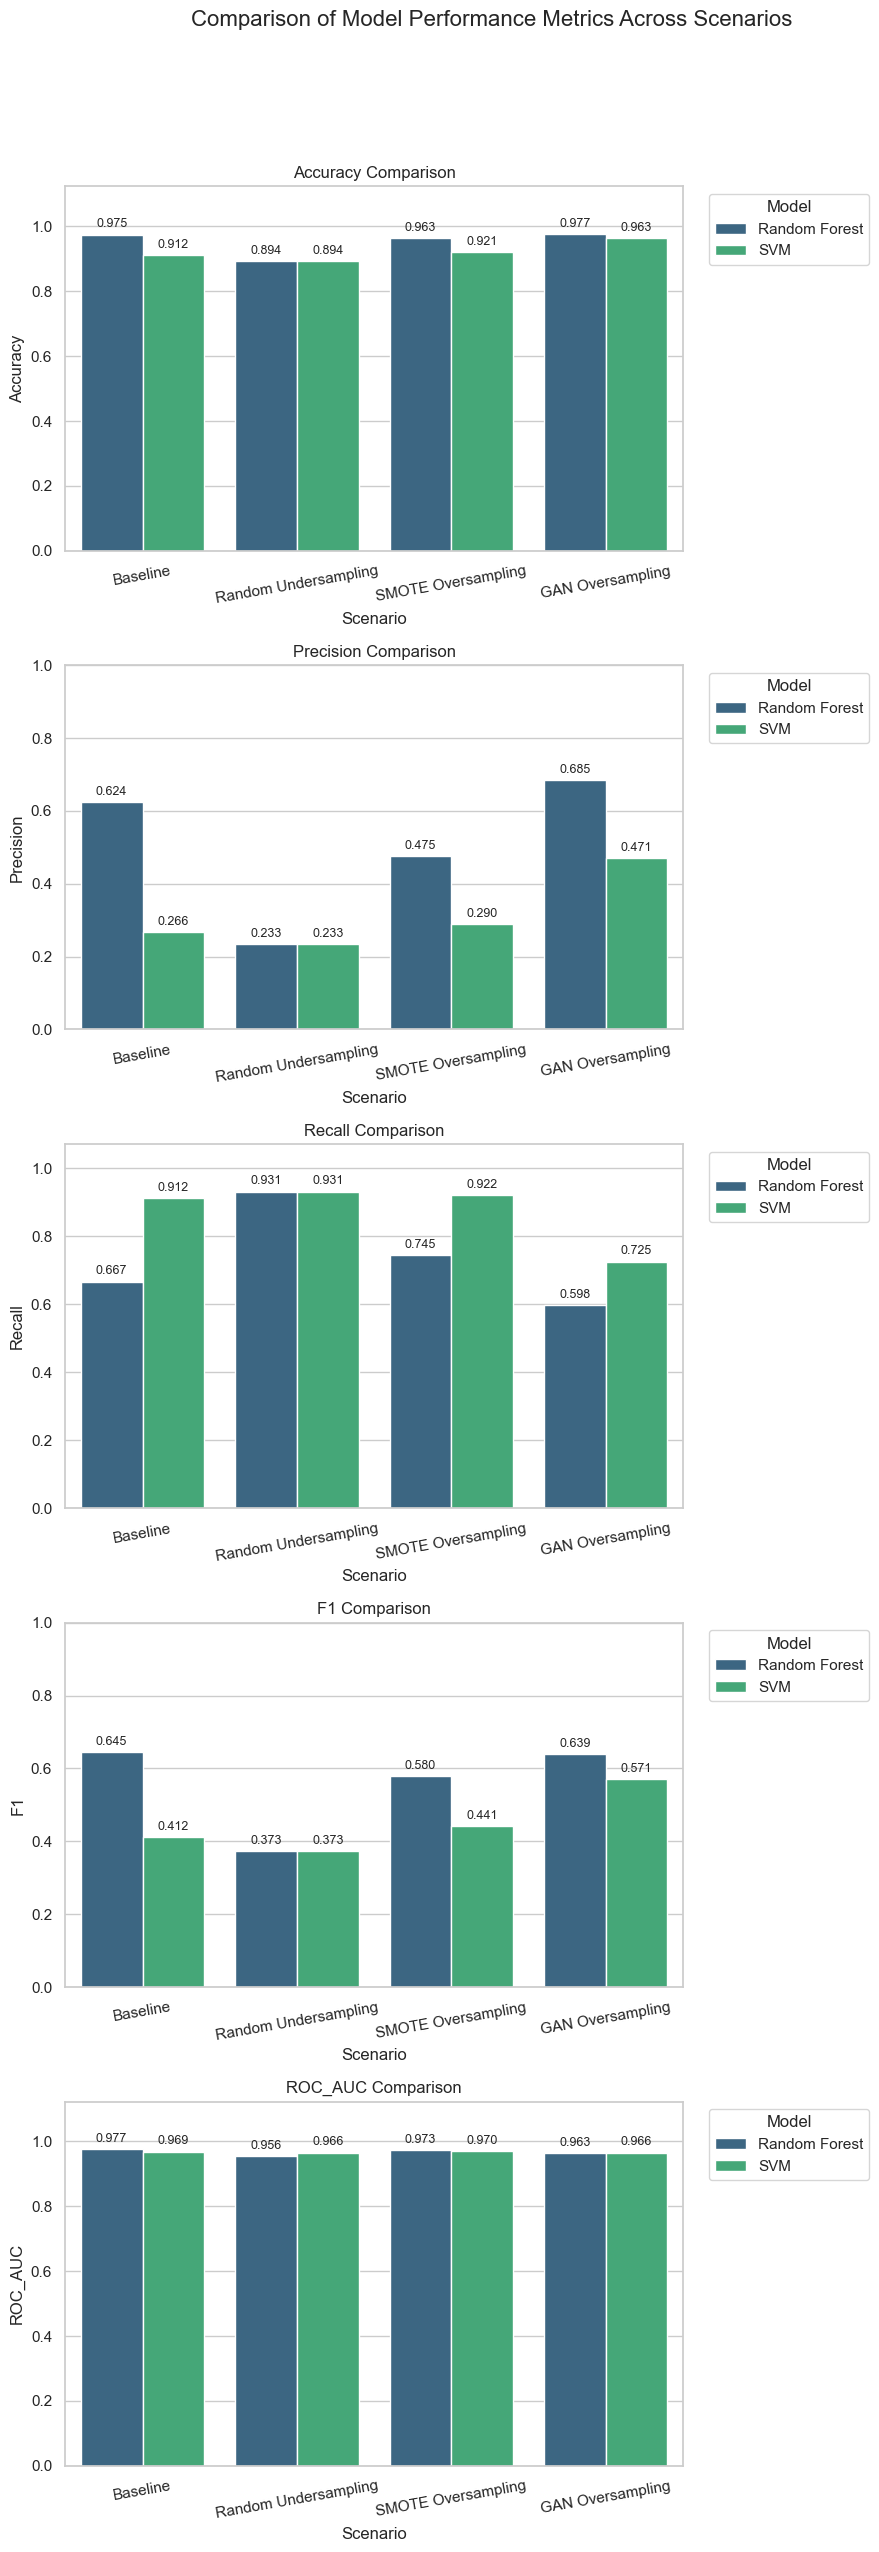

In [18]:
# Convert results dictionary to DataFrame, handling potential missing scenarios
results_final = {}
for scenario_key in ['Baseline', 'Random Undersampling', 'SMOTE Oversampling', 'GAN Oversampling']:
    if scenario_key in results:
         for model_key, metrics_val in results[scenario_key].items():
             if metrics_val and not all(np.isnan(list(metrics_val.values()))): # Check if metrics dict is not empty/all NaN
                 results_final[(scenario_key, model_key)] = metrics_val
             # Keep placeholder logic if needed based on how skipped scenarios are handled
             # elif scenario_key not in results_final:
             #     results_final[(scenario_key, 'Random Forest')] = {m: np.nan for m in metrics_dict}
             #     results_final[(scenario_key, 'SVM')] = {m: np.nan for m in metrics_dict}
    else:
         # Add placeholders if a scenario was entirely skipped/failed before results dict entry was created
         results_final[(scenario_key, 'Random Forest')] = {m: np.nan for m in metrics_dict}
         results_final[(scenario_key, 'SVM')] = {m: np.nan for m in metrics_dict}


if results_final: # Proceed only if there are results to show
    results_df = pd.DataFrame.from_dict(results_final, orient='index')
    # Rename index levels for clarity
    results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Scenario', 'Model'])
    # Format the DataFrame for better readability
    results_df_formatted = results_df.style.format("{:.4f}", na_rep="N/A").set_caption("Model Performance Metrics Across Scenarios")

    print("\n--- Comparative Results ---")
    display(results_df_formatted)

    # --- Visualization of Results ---
    # Define metrics *before* using dropna
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    results_to_plot = results_df.reset_index().dropna(subset=metrics_to_plot, how='all') # Drop rows ONLY if ALL metrics are NaN

    if not results_to_plot.empty:
        n_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(10, 5 * n_metrics)) # Adjusted height
        if n_metrics == 1: axes = [axes] # Ensure axes is iterable

        fig.suptitle('Comparison of Model Performance Metrics Across Scenarios', fontsize=16, y=1.02)

        scenario_order = ['Baseline', 'Random Undersampling', 'SMOTE Oversampling', 'GAN Oversampling']
        # Filter results_to_plot to only include scenarios present and maintain order
        available_scenarios_in_order = [s for s in scenario_order if s in results_to_plot['Scenario'].unique()]
        results_to_plot['Scenario'] = pd.Categorical(results_to_plot['Scenario'], categories=available_scenarios_in_order, ordered=True)
        # results_to_plot = results_to_plot.sort_values('Scenario') # Optional sort if needed


        for i, metric in enumerate(metrics_to_plot):
            # Check if the metric exists and has non-NaN values before plotting
            if metric in results_to_plot.columns and results_to_plot[metric].notna().any():
                sns.barplot(data=results_to_plot, x='Scenario', y=metric, hue='Model', ax=axes[i], palette='viridis', order=available_scenarios_in_order)
                axes[i].set_title(f'{metric} Comparison')
                axes[i].set_ylabel(metric)
                axes[i].set_xlabel('Scenario')
                axes[i].tick_params(axis='x', rotation=10)
                axes[i].legend(title='Model', bbox_to_anchor=(1.03, 1), loc='upper left')

                for container in axes[i].containers:
                    axes[i].bar_label(container, fmt='%.3f', label_type='edge', padding=3, fontsize=9) # Adjusted padding/fontsize

                min_val = 0
                max_val = max(1.0, results_to_plot[metric].max() * 1.15) if results_to_plot[metric].notna().any() else 1.0
                axes[i].set_ylim(bottom=min_val, top=max_val)
            else:
                axes[i].set_title(f'{metric} Comparison (No Data)')
                axes[i].text(0.5, 0.5, 'No data to display', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

        plt.tight_layout(rect=[0, 0, 0.9, 0.98]) # Adjust rect to prevent title overlap and legend cutoff
        plt.show()
    else:
        print("No valid results available for plotting (perhaps all scenarios failed or were skipped).")

else:
    print("No results were generated to display.")

**Results Summary & Visualization Explanation:**
*   The code compiles results from the `results` dictionary into a pandas DataFrame. It handles potential cases where a scenario (like GAN) might have failed or been skipped.
*   A multi-level index (`Scenario`, `Model`) organizes the data clearly. Metrics are formatted for readability.
*   A series of bar charts visualizes the performance (Accuracy, Precision, Recall, F1-score, and ROC-AUC) of both Random Forest and SVM across the different scenarios (Baseline, Random Undersampling, SMOTE Oversampling, GAN Oversampling using TabGAN).
*   This allows for direct comparison of the effectiveness and trade-offs of each imbalance handling technique.

## 9. Conclusion

**[Thesis Author: Fill in based on the generated results]**

*   Compare baseline performance (likely high accuracy, low recall) with the resampling methods.
*   Analyze the impact of RUS (likely increased recall, decreased precision/accuracy).
*   Analyze the impact of SMOTE (aims for balanced improvement, compare vs. RUS).
*   Analyze the impact of TabGAN (if successful - compare quality vs. SMOTE/RUS, consider computation time, note use of `X_test` in generation pipe).
*   Determine the best overall Scenario/Model combination based on key metrics (Recall, F1, ROC-AUC).
*   Discuss implications and future work directions.

## 10. Troubleshooting & Library Notes

**TabGAN and Dependencies (GPU Focus):**
*   **Installation:** Ensure `tabgan` is installed (`pip install tabgan`). For GPU support, you need a compatible version of PyTorch installed with CUDA support. Follow instructions on the official PyTorch website ([https://pytorch.org/get-started/locally/](https://pytorch.org/get-started/locally/)) for your specific OS and CUDA version.
*   **GPU Not Detected by PyTorch:** If the GPU Check cell indicates PyTorch doesn't see your CUDA device:
    *   Verify correct NVIDIA driver installation.
    *   Confirm compatible CUDA Toolkit and cuDNN versions are installed and their paths are correctly set in environment variables.
    *   Ensure you installed the CUDA-enabled version of PyTorch (the command usually includes `+cuXXX` or specifies a CUDA index URL).
    *   Check if other processes are using the GPU memory.
*   **CUDA Errors during TabGAN run:** Errors mentioning CUDA (e.g., "CUDA out of memory", "invalid device function") usually point to issues with the PyTorch CUDA installation, driver/CUDA version mismatch, or insufficient GPU memory.
    *   *Out of Memory:* Try reducing `batch_size` within the `gen_params` argument of `GANGenerator`. You might also need to reduce GAN network complexity if the library allows it (check `tabgan` documentation for advanced parameters).
    *   *Other CUDA errors:* Revisit PyTorch installation steps for your specific CUDA version.
*   **`generate_data_pipe` Issues:** Ensure `X_train`, `y_train`, and `X_test` are pandas DataFrames/Series as expected. The `y_train` input specifically needs to be a DataFrame or Series (code was adjusted to handle this). Check the library's documentation for the exact expected input types and parameter names if errors persist.
*   **`cuda` argument:** The explicit `cuda=True` argument was removed from `GANGenerator` initialization as it caused a `TypeError` in version 2.2.2. GPU usage should now rely on PyTorch's automatic CUDA detection.

**General:**
*   **Long Runtimes:** GridSearchCV and GAN training (even on GPU) can be lengthy. For testing/debugging, use smaller parameter grids (`param_grid_rf`, `param_grid_svm`) and fewer epochs/smaller batch sizes in `gen_params` for TabGAN. Increase them for final runs.
*   **Kernel Restarts:** If you encounter persistent errors or memory issues, restarting the Jupyter kernel can sometimes resolve temporary states.

In [19]:
print("Notebook execution complete.")
print("\nFinal Comparative Results Table:")
if 'results_df_formatted' in locals():
    display(results_df_formatted)
else:
    print("Result generation was incomplete or failed.")

Notebook execution complete.

Final Comparative Results Table:
